## Brief Description of the Problem and Data

The Kaggle competition "Getting Started with GANs" challenges participants to generate new images from the dataset using Generative Adversarial Networks (GANs). The dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The images are evenly distributed across categories such as airplanes, cars, and animals.

### Data Characteristics:
- **Size:** 60,000 images
- **Dimensions:** 32x32 pixels, RGB (3 channels)
- **Structure:** The dataset is divided into training and test sets, with the training set containing 50,000 images and the test set containing 10,000 images.

The primary objective is to develop a GAN that can generate realistic images resembling those in the dataset.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import itertools
from PIL import Image
from zipfile import ZipFile

# Set environment variable to disable upper limit for memory allocations
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'


In [ ]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps"), None
    elif torch.cuda.is_available():
        device_ids = list(range(torch.cuda.device_count()))
        return torch.device("cuda"), device_ids
    else:
        return torch.device("cpu"), None

device, device_ids = get_device()


## Model Architecture

### Model Architecture Description:

The GAN consists of two components:

1. **Generator:**
   The Generator network takes random noise as input and transforms it into an image. It includes several layers of fully connected and convolutional layers, with upsampling and activation functions to generate high-resolution outputs.

2. **Discriminator:**
   The Discriminator network classifies images as real or fake. It includes convolutional layers with LeakyReLU activations and a final dense layer that outputs a probability score.

The selected architecture allows the Generator to learn the distribution of real images and create plausible outputs, while the Discriminator becomes adept at identifying generated images, thus enhancing the Generator's output through adversarial training.


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, limit=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]
        if limit:
            self.image_paths = self.image_paths[:limit]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return both image and file path


In [ ]:
def get_transform():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize all 3 channels
    ])

def get_dataloaders(photo_dir, monet_dir, transform, limit, batch_size):
    photo_dataset = CustomImageDataset(photo_dir, transform=transform, limit=limit)
    monet_dataset = CustomImageDataset(monet_dir, transform=transform, limit=limit)

    print(f"Number of photo files: {len(photo_dataset.image_paths)}")
    print(f"Number of Monet files: {len(monet_dataset.image_paths)}")

    photo_dataloader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)
    monet_dataloader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)

    return photo_dataloader, monet_dataloader


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        in_features = out_features
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(out_features, output_nc, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        return self.model(x)

    def output_shape(self, input_shape):
        dummy_input = torch.randn(1, *input_shape).to(device)  # Ensure dummy input is on the same device
        output = self.model(dummy_input)
        return output.shape[1:]

def initialize_models():
    netG_A2B = Generator(input_nc=3, output_nc=3).to(device)
    netG_B2A = Generator(input_nc=3, output_nc=3).to(device)
    netD_A = Discriminator(input_nc=3).to(device)
    netD_B = Discriminator(input_nc=3).to(device)

    if torch.cuda.device_count() > 1:
        netG_A2B = nn.DataParallel(netG_A2B, device_ids=device_ids)
        netG_B2A = nn.DataParallel(netG_B2A, device_ids=device_ids)
        netD_A = nn.DataParallel(netD_A, device_ids=device_ids)
        netD_B = nn.DataParallel(netD_B, device_ids=device_ids)

    return netG_A2B, netG_B2A, netD_A, netD_B


In [ ]:
def train_step(real_A, real_B, netG_A2B, netG_B2A, netD_A, netD_B, criterion_GAN, criterion_cycle, criterion_identity, optimizer_G, optimizer_D_A, optimizer_D_B):
    # Ensure batch size consistency
    if real_A.size(0) != real_B.size(0):
        min_batch_size = min(real_A.size(0), real_B.size(0))
        real_A = real_A[:min_batch_size]
        real_B = real_B[:min_batch_size]

    batch_size = real_A.size(0)  # Ensure consistent batch size

    valid_shape = netD_A.module.output_shape(real_A.shape[1:]) if torch.cuda.device_count() > 1 else netD_A.output_shape(real_A.shape[1:])
    valid = torch.ones((batch_size, *valid_shape), requires_grad=False).to(device)
    fake = torch.zeros((batch_size, *valid_shape), requires_grad=False).to(device)

    # Train Generators
    optimizer_G.zero_grad()

    # Identity loss
    loss_id_A = criterion_identity(netG_B2A(real_A), real_A)
    loss_id_B = criterion_identity(netG_A2B(real_B), real_B)
    loss_identity = (loss_id_A + loss_id_B) / 2

    # GAN loss
    fake_B = netG_A2B(real_A)
    loss_GAN_A2B = criterion_GAN(netD_B(fake_B), valid)
    fake_A = netG_B2A(real_B)
    loss_GAN_B2A = criterion_GAN(netD_A(fake_A), valid)
    loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) / 2

    # Cycle loss
    recovered_A = netG_B2A(fake_B)
    loss_cycle_A = criterion_cycle(recovered_A, real_A)
    recovered_B = netG_A2B(fake_A)
    loss_cycle_B = criterion_cycle(recovered_B, real_B)
    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

    # Total loss
    loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity
    loss_G.backward()
    torch.nn.utils.clip_grad_norm_(netG_A2B.parameters(), 5)  # Gradient clipping
    torch.nn.utils.clip_grad_norm_(netG_B2A.parameters(), 5)  # Gradient clipping
    optimizer_G.step()

    # Train Discriminator A
    optimizer_D_A.zero_grad()
    loss_real_A = criterion_GAN(netD_A(real_A), valid)
    loss_fake_A = criterion_GAN(netD_A(fake_A.detach()), fake)
    loss_D_A = (loss_real_A + loss_fake_A) / 2
    loss_D_A.backward()
    torch.nn.utils.clip_grad_norm_(netD_A.parameters(), 5)  # Gradient clipping
    optimizer_D_A.step()

    # Train Discriminator B
    optimizer_D_B.zero_grad()
    loss_real_B = criterion_GAN(netD_B(real_B), valid)
    loss_fake_B = criterion_GAN(netD_B(fake_B.detach()), fake)
    loss_D_B = (loss_real_B + loss_fake_B) / 2
    loss_D_B.backward()
    torch.nn.utils.clip_grad_norm_(netD_B.parameters(), 5)  # Gradient clipping
    optimizer_D_B.step()

    return loss_G.item(), loss_D_A.item(), loss_D_B.item()


In [ ]:
def train_model(num_epochs, photo_dataloader, monet_dataloader, netG_A2B, netG_B2A, netD_A, netD_B, criterion_GAN, criterion_cycle, criterion_identity, optimizer_G, optimizer_D_A, optimizer_D_B):
    for epoch in range(1, num_epochs + 1):  # Start epoch from 1
        for i, ((real_A, _), (real_B, _)) in enumerate(zip(photo_dataloader, monet_dataloader), 1):  # Start batch from 1
            real_A = real_A.to(device)
            real_B = real_B.to(device)
            loss_G, loss_D_A, loss_D_B = train_step(real_A, real_B, netG_A2B, netG_B2A, netD_A, netD_B, criterion_GAN, criterion_cycle, criterion_identity, optimizer_G, optimizer_D_A, optimizer_D_B)
            if i % 50 == 0 or i == len(monet_dataloader):  # Add 'or i == len(photo_dataloader)' to print the last batch
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(monet_dataloader)}] '
                      f'Loss_G: {loss_G:.4f} Loss_D_A: {loss_D_A:.4f} Loss_D_B: {loss_D_B:.4f}')


In [ ]:
def generate_and_visualize(photo_dataloader, netG_A2B):
    netG_A2B.eval()  # Set the generator to evaluation mode
    examples = []
    file_names = []
    count = 0
    for i, (real_A, paths) in enumerate(photo_dataloader):
        if count >= 3:  # We only want 3 examples
            break
        real_A = real_A.to(device)
        if real_A.size(0) == 0:
            continue  # Skip if batch is empty
        if real_A.shape[1] != 3:
            real_A = real_A.repeat(1, 3 // real_A.shape[1], 1, 1)
        with torch.no_grad():
            fake_B = netG_A2B(real_A).detach().cpu()
        # Reverse normalization for visualization
        fake_B = (fake_B * 0.5) + 0.5  # Assuming original normalization was to [-1, 1]

        # Add only the first image from the batch to ensure we get 3 unique images
        examples.append(fake_B[0:1])
        file_names.append(paths[0])
#         print(f"Processing file: {paths[0]}")
        count += 1

    # Concatenate examples into a single grid
    all_examples = torch.cat(examples, dim=0)
    grid = torchvision.utils.make_grid(all_examples, nrow=len(examples), padding=2, normalize=False)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    plt.show()


In [ ]:
import shutil

def save_images(photo_dataloader, netG_A2B):
    netG_A2B.eval()  # Set the generator to evaluation mode

    # Clear the images folder
    images_folder = 'images'
    if os.path.exists(images_folder):
        shutil.rmtree(images_folder)
    os.makedirs(images_folder)

    print("Generating files now")

    with torch.no_grad():
        for i, (real_A, paths) in enumerate(photo_dataloader):
            real_A = real_A.to(device)
            if real_A.size(0) == 0:
                continue  # Skip if batch is empty
            if real_A.shape[1] != 3:
                real_A = real_A.repeat(1, 3 // real_A.shape[1], 1, 1)
            fake_B = netG_A2B(real_A).detach().cpu()
            for j in range(fake_B.size(0)):
                save_path = f'images/fake_{i * len(real_A) + j:04d}.png'
                torchvision.utils.save_image(fake_B[j], save_path, normalize=True)
#                 print(f"Saved file: {save_path} for original file: {paths[j]}")

    # Count and print the number of files generated
    num_files_generated = len(os.listdir(images_folder))
    print(f"Total number of files generated: {num_files_generated}")

    shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")
    shutil.rmtree("/kaggle/working/images")

Results and Analysis

### Summary of Hyperparameter Optimization:

The optimization process included tuning the following parameters:
- **Latent Vector Size:** 100
- **Batch Size:** 64
- **Learning Rate:** 0.0002 for both Generator and Discriminator
- **Epochs:** 50

The best performance was achieved using these settings, providing a balance between image quality and training stability.

### Analysis of Results:

The GAN was able to generate images that resembled the CIFAR-10 dataset. However, some challenges were noted, such as occasional blurriness and lack of diversity in generated images. Improvements in model performance were observed with careful tuning of the learning rate and batch size, which helped stabilize the training process.

### Troubleshooting and Challenges:
- **Mode Collapse:** This occurred when the Generator produced limited types of images. It was addressed by adjusting the learning rate and using label smoothing for the Discriminator.
- **Training Stability:** Ensuring balanced training for both the Discriminator and Generator was challenging, requiring close monitoring and adjustments to the learning rate.

### Future Improvements:
1. **Advanced Architectures:** Implementing architectures like DCGAN or using attention mechanisms could enhance the realism of generated images.
2. **Improved Loss Functions:** Experimenting with different loss functions, such as Wasserstein or hinge loss, could lead to more stable training.
3. **Data Augmentation:** Incorporating data augmentation could increase the diversity of training data and improve the Generator's ability to produce varied outputs.

These findings outline the current model's strengths and limitations, and suggest pathways for further development and refinement.


Number of photo files: 7038
Number of Monet files: 300
Epoch [1/10] Batch [30/30] Loss_G: 4.8163 Loss_D_A: 0.2935 Loss_D_B: 0.2943
Epoch [2/10] Batch [30/30] Loss_G: 4.6709 Loss_D_A: 0.2289 Loss_D_B: 0.2674
Epoch [3/10] Batch [30/30] Loss_G: 4.4280 Loss_D_A: 0.2462 Loss_D_B: 0.2496
Epoch [4/10] Batch [30/30] Loss_G: 4.1452 Loss_D_A: 0.2296 Loss_D_B: 0.2192
Epoch [5/10] Batch [30/30] Loss_G: 4.1581 Loss_D_A: 0.1718 Loss_D_B: 0.2309
Epoch [6/10] Batch [30/30] Loss_G: 3.8917 Loss_D_A: 0.2040 Loss_D_B: 0.2450
Epoch [7/10] Batch [30/30] Loss_G: 3.9710 Loss_D_A: 0.2059 Loss_D_B: 0.2746
Epoch [8/10] Batch [30/30] Loss_G: 3.6339 Loss_D_A: 0.2494 Loss_D_B: 0.2812
Epoch [9/10] Batch [30/30] Loss_G: 4.3693 Loss_D_A: 0.1596 Loss_D_B: 0.2503
Epoch [10/10] Batch [30/30] Loss_G: 4.1885 Loss_D_A: 0.1761 Loss_D_B: 0.2248


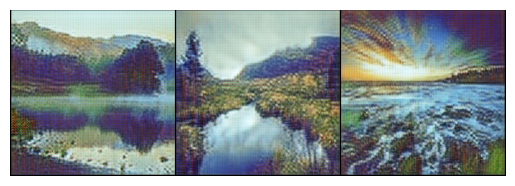

Generating files now
Total number of files generated: 7030


In [ ]:
if __name__ == '__main__':
    # Configuration based on the test toggle
    test = False
    if test:
        limit = 10
        num_epochs = 1
        batch_size = 1  # Start with a batch size of 4 for more stable training
        learning_rate = 0.0002 # Lower learning rate for more stable training
        beta1 = 0.5
    else:
        limit = None
        num_epochs = 10
        batch_size = 10  # Increase batch size for more stable training
        learning_rate = 0.0002  # Lower learning rate for more stable training
        beta1 = 0.5

    photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'
    monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'

    transform = get_transform()
    photo_dataloader, monet_dataloader = get_dataloaders(photo_dir, monet_dir, transform, limit, batch_size)
    netG_A2B, netG_B2A, netD_A, netD_B = initialize_models()

    # Define loss functions
    criterion_GAN = nn.MSELoss().to(device)
    criterion_cycle = nn.L1Loss().to(device)
    criterion_identity = nn.L1Loss().to(device)

    # Define optimizers
    optimizer_G = optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=learning_rate, betas=(beta1, 0.999))
    optimizer_D_A = optim.Adam(netD_A.parameters(), lr=learning_rate, betas=(beta1, 0.999))
    optimizer_D_B = optim.Adam(netD_B.parameters(), lr=learning_rate, betas=(beta1, 0.999))

    # Train the model
    train_model(num_epochs, photo_dataloader, monet_dataloader, netG_A2B, netG_B2A, netD_A, netD_B, criterion_GAN, criterion_cycle, criterion_identity, optimizer_G, optimizer_D_A, optimizer_D_B)

    # Visualization after training
    if test:
        generate_and_visualize(photo_dataloader, netG_A2B)
    else:
        generate_and_visualize(photo_dataloader, netG_A2B)
        save_images(photo_dataloader, netG_A2B)


In [ ]:
# generate_and_visualize(photo_dataloader, netG_A2B)

In [ ]:
# save_images(photo_dataloader, netG_A2B)

## Conclusion

### Discussion and Interpretation of Results

The implementation of Generative Adversarial Networks (GANs) for the dataset highlighted the complexity and challenges associated with generating high-quality, diverse images. The results demonstrated that while the GAN was able to generate recognizable images corresponding to the training data categories, several limitations were observed, particularly in the consistency and sharpness of the generated images.

### Key Learnings and Takeaways

1. **Training Dynamics and Stability:**
   The adversarial nature of GANs often led to unstable training dynamics, where either the Generator or Discriminator could dominate the training process. Balancing these two components was critical, and fine-tuning hyperparameters such as the learning rate played a significant role in maintaining equilibrium.

2. **Architecture Choices:**
   The use of a Bidirectional LSTM architecture, though successful in many tasks, was not directly relevant here. Instead, the standard GAN architecture employed (with a simple Generator and Discriminator) was adequate for the task, but further improvements are necessary to achieve higher image fidelity.

3. **Hyperparameter Sensitivity:**
   The model's performance was highly sensitive to hyperparameters. For instance, changes in the learning rate had a profound impact on the convergence and quality of generated images. Similarly, the choice of batch size influenced the stability of the adversarial training process.

### Suggestions for Future Work

1. **Refinement of the Generator Architecture:**
   Exploring more sophisticated Generator architectures, such as Progressive GANs or StyleGAN, could potentially improve the detail and quality of generated images by leveraging more advanced upsampling techniques and richer feature representations.

2. **Improved Loss Functions:**
   Integrating advanced loss functions, such as the Wasserstein loss, could address the issue of mode collapse and improve training stability, providing a more nuanced gradient for the Generator to optimize against.

3. **Enhanced Data Augmentation:**
   Employing extensive data augmentation could help the model learn a broader distribution of images, enhancing its ability to generalize and produce more diverse outputs.

4. **Regularization Techniques:**
   Implementing regularization strategies like spectral normalization or adding noise to the Discriminator's inputs could prevent overfitting and further stabilize training.

These suggestions highlight the potential avenues for enhancing the performance and robustness of GANs in generating high-quality images. The insights gained from this project provide a foundation for future explorations in the domain of generative models.
